# Semantic Segmentation - Basics

In digital image processing and computer vision, image segmentation is the process of partitioning a digital image into multiple segments. The goal of segmentation is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze.

## Import the modules

In [1]:
import torch

In [2]:
import jovian

In [3]:
import torchvision

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
import numpy as np

### FCN with Resnet-101

FCN - Fully Convolutional Netowrks, are among the most early invented Neural Networks for the task of Semantic Segmentation.

In [6]:
from torchvision import models
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

Now that we have,a pretrained model of FCN (which stands for Fully Convolutional Neural Networks) with Resnet101.<br>
Lets load an image.
<br>
I love dogs, so I used this, u may choose whatever u like.

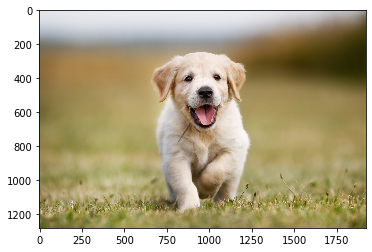

In [7]:
img = Image.open('./images/dog.jpg')
plt.imshow(img); plt.show()

Now, that we have the image we need to preprocess it and normalize it! <br/>
So, for the preprocessing steps, we:
- Resize the image to `(256 x 256)`
- CenterCrop it to `(224 x 224)`
- Convert it to Tensor - all the values in the image becomes between `[0, 1]` from `[0, 255]`
- Normalize it with the Imagenet specific values `mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]`

And lastly, we unsqueeze the image so that it becomes `[1 x C x H x W]` from `[C x H x W]` <br/>
We need a batch dimension while passing it to the models.

In [8]:
# Apply the transformations needed
import torchvision.transforms as T
trf = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

Let's see what the above code cell does </br>
`T.Compose` is a function that takes in a `list` in which each element is of `transforms` type and </br>
it returns a object through which we can
pass batches of images and all the required transforms will be applied to the images.

Let's take a look at the transforms applied on the images:
- `T.Resize(256)` : Resizes the image to size `256 x 256`
- `T.CenterCrop(224)` : Center Crops the image to have a resulting size of `224 x 224`
- `T.ToTensor()` : Converts the image to type `torch.Tensor` and have values between `[0, 1]`
- `T.Normalize(mean, std)` : Normalizes the image with the given mean and standard deviation.

The output of the model is a `OrderedDict` so, we need to take the `out` key from that to get the output of the model.

In [9]:
# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

torch.Size([1, 21, 224, 224])


We can see, its shape is `[1 x 21 x H x W]`. So, the model was trained on `21` classes and thus our output have `21` channels!<br/>

Now, what we need to do is make this `21` channeled output into a `2D` image or a `1` channeled image, where each pixel of that image corresponds to a class!

So, the `2D` image, (of shape `[H x W]`) will have each pixel corresponding to a class label, and thus <br/>
for each `(x, y)` in this `2D` image will correspond to a number between `0 - 20` representing a class.

We take a max index for each pixel position, which represents the class<br/>

In [10]:
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

(224, 224)
[ 0 12]


We can see now have a `2D` image. Where each pixel corresponds to a class!
The last thing is to take this `2D` image where each pixel corresponds to a class label and convert this<br/>
into a segmentation map where each class label is converted into a `RGB` color and thus helping in easy visualization.

We will use the following function to convert this `2D` image to an `RGB` image wheree each label is mapped to its
corresponding color.

In [11]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

Let's see what we are doing inside this function!

first `label_colors` stores the colors for each of the clases, according to the index </br>
So, the color for the  first class which is `background` is stored in the `0`th index of the `label_colors` list, 
the second class which is `aeroplane` is stored at index `1` of `label_colors`.

Now, we are to create an `RGB` image from the `2D` image passed. So, what we do, is we create empty `2D` matrices for all 3 channels.

So, `r`, `g`, and `b` are arrays which will form the `RGB` channels for the final image. And each are of shape `[H x W]` 
(which is same as the shape of `image` passed in)

Now, we loop over each class color we stored in `label_colors`.
And we get the indexes in the image where that particular class label is present. (`idx = image == l`)
And then for each channel, we put its corresponding color to those pixels where that class label is present.

And finally we stack the 3 seperate channels to form a `RGB` image.

Okay! Now, let's use this function to see the final segmented output from the original one!!

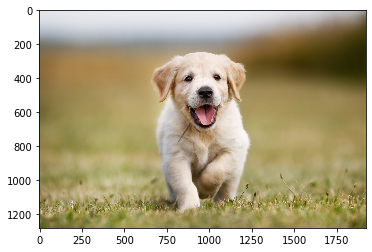

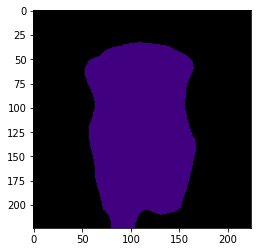

In [12]:
rgb = decode_segmap(om)
plt.imshow(img); plt.show()
plt.imshow(rgb); plt.show()

And there we go!!<br/>
We have segmented the output of the image. 

That's our cute dog!

Also, Do note that the image after segmentation is smaller than the original image as in the preprocessing step the image is resized and cropped.

Next, let's move all this under one function and play with a few more images!

<div class="alert alert-danger"><h3>Warning :</h3>
    <br>
    <strong>
        DO NOT CALL segment_gpu unless u have a nvidia GPU with cuda enabled, call segment_cpu instead
        Even an i5 with 8 GB RAM isn't enough to process this, so do not use segment_gpu unless u have atleast a dedicated GPU (GEFORCE GTX 1080 Ti) and all other models above this should work.
    </strong>
</div>

In [13]:
def segment_gpu(net, path, show_orig=True, dev='cuda'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([# T.Resize(640), 
                   # T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0)
  out = net.to(dev)(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.axis('off'); plt.show()

In [14]:
def segment_cpu(net, path, show_orig=True, dev='cpu'):
  img = Image.open(path)
  if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
  # Comment the Resize and CenterCrop for better inference results
  trf = T.Compose([T.Resize(256),
                     T.CenterCrop(224),
                     T.ToTensor(), 
                     T.Normalize(mean = [0.485, 0.456, 0.406], 
                                 std = [0.229, 0.224, 0.225])])
  inp = trf(img).unsqueeze(0)
  out = fcn(inp)['out']
  om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
  rgb = decode_segmap(om)
  plt.imshow(rgb); plt.show()

### Tested on flower image :

Enter 1 for GPU, 2 for CPU: 2


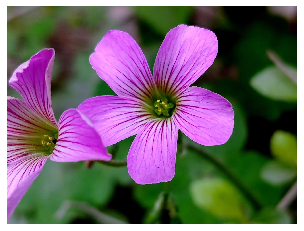

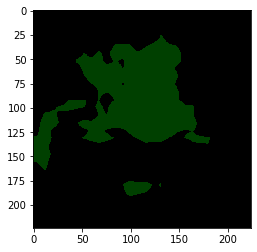

In [15]:
n = input("Enter 1 for GPU, 2 for CPU: ")
file_loc = './images/flower.jpg'
if(n == 1):
    segment_gpu(fcn, file_loc)
else:    
    segment_cpu(fcn, file_loc)

### Tested on Human image :

Enter 1 for GPU, 2 for CPU: 2


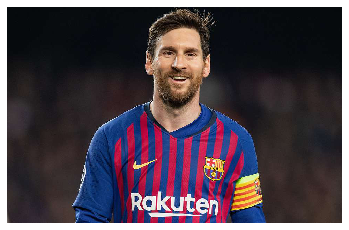

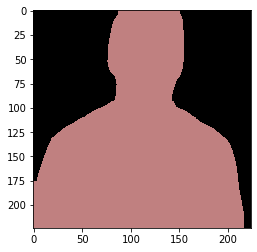

In [16]:
n = input("Enter 1 for GPU, 2 for CPU: ")
file_loc = './images/messi.jpg'
if(n == 1):
    segment_gpu(fcn, file_loc)
else:    
    segment_cpu(fcn, file_loc)

Enter 1 for GPU, 2 for CPU: 2


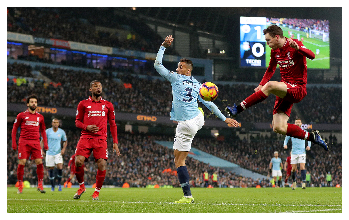

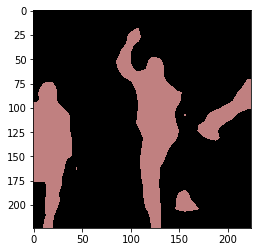

In [17]:
n = input("Enter 1 for GPU, 2 for CPU: ")
file_loc = './images/many_ppl.jpg'
if(n == 1):
    segment_gpu(fcn, file_loc)
else:    
    segment_cpu(fcn, file_loc)

## Now lets try it on DeepLabv3

In [18]:
dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

Enter 1 for GPU, 2 for CPU: 2


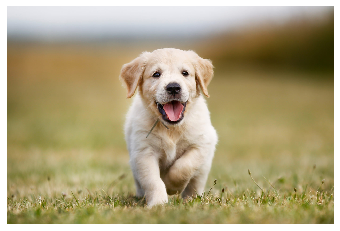

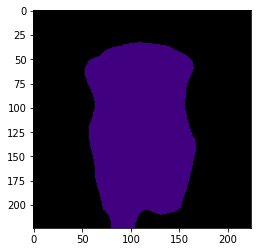

In [19]:
n = input("Enter 1 for GPU, 2 for CPU: ")
file_loc = './images/dog.jpg'
if(n == 1):
    segment_gpu(fcn, file_loc)
else:    
    segment_cpu(fcn, file_loc)

Enter 1 for GPU, 2 for CPU: 2


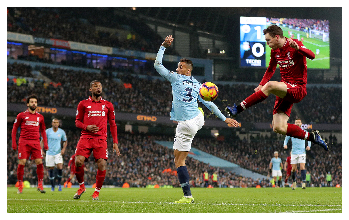

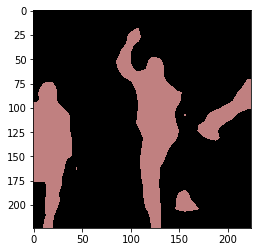

In [20]:
n = input("Enter 1 for GPU, 2 for CPU: ")
file_loc = './images/many_ppl.jpg'
if(n == 1):
    segment_gpu(fcn, file_loc)
else:    
    segment_cpu(fcn, file_loc)

## Comparision - Inference Time

For, now we will see how these two models compare with each other

In [21]:
import time

def infer_time(net, path='./images/dog.jpg', dev='cpu'):
  img = Image.open(path)
  trf = T.Compose([T.Resize(256), 
                   T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
  
  inp = trf(img).unsqueeze(0).to(dev)
  
  st = time.time()
  out1 = net.to(dev)(inp)
  et = time.time()
  
  return et - st

#### Note : If u want more accuracy, u can increase avg_ovr, but it depends upon the environment you are using

In [22]:
# If u want more accuracy, u can increase avg_ovr, but it depends upon the environment you are using
avg_over = 10

fcn_infer_time_list_cpu = [infer_time(fcn, dev='cpu') for _ in range(avg_over)]
fcn_infer_time_avg_cpu = sum(fcn_infer_time_list_cpu) / avg_over

dlab_infer_time_list_cpu = [infer_time(dlab, dev='cpu') for _ in range(avg_over)]
dlab_infer_time_avg_cpu = sum(dlab_infer_time_list_cpu) / avg_over


print ('Inference time for first few calls for FCN      : {}'.format(fcn_infer_time_list_cpu[:10]))
print ('Inference time for first few calls for DeepLabv3: {}'.format(dlab_infer_time_list_cpu[:10]))

print ('The Average Inference time on FCN is:     {:.2f}s'.format(fcn_infer_time_avg_cpu))
print ('The Average Inference time on DeepLab is: {:.2f}s'.format(dlab_infer_time_avg_cpu))

Inference time for first few calls for FCN      : [1.1424493789672852, 1.1664140224456787, 1.1139135360717773, 1.1154518127441406, 1.1373844146728516, 1.4030802249908447, 1.1298000812530518, 1.8587191104888916, 1.1277918815612793, 1.8174872398376465]
Inference time for first few calls for DeepLabv3: [1.1585474014282227, 1.864137887954712, 1.1952784061431885, 1.8420989513397217, 1.3402822017669678, 1.6385409832000732, 1.3080682754516602, 1.6906259059906006, 1.20265531539917, 1.2607536315917969]
The Average Inference time on FCN is:     1.30s
The Average Inference time on DeepLab is: 1.45s


<br><br>
We can see that in case of CPU its taking longer for the DeepLabv3 model, as its a much deeper model as compared to FCN.

Also, we have printed out the first few inference times for each model. Something we can notice is that the inference time for the first call
takes quite long than the others . This is because after the 1st call a lot of the calculations required are cached and thus its faster for the next calls.

Nice! Now, let's try to vizualize the difference in the time taken for the CPU.

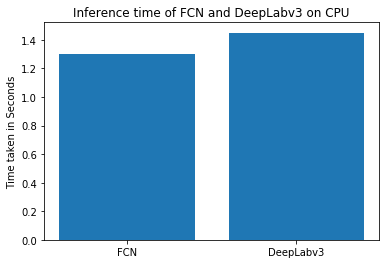

In [24]:
plt.bar([0.1, 0.2], [fcn_infer_time_avg_cpu, dlab_infer_time_avg_cpu], width=0.08)
plt.ylabel('Time taken in Seconds')
plt.xticks([0.1, 0.2], ['FCN', 'DeepLabv3'])
plt.title('Inference time of FCN and DeepLabv3 on CPU')
plt.show()